In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import datasets, preprocessing

import os
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm

# I. 데이터 수집 및 로드

In [2]:
train = pd.read_csv('./data/FIFA_train.csv')
test = pd.read_csv('./data/FIFA_test.csv')
submission = pd.read_csv('./data/submission.csv')

In [3]:
train.tail(3)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
8929,16941,N. Fuentes,18,south america,2021,DF,right,1.0,47,64,2.0,50000.0
8930,16942,J. Milli,18,europe,2021,GK,right,1.0,47,65,1.0,50000.0
8931,16948,N. Christoffersson,19,europe,2020,ST,right,1.0,47,63,2.0,60000.0


In [4]:
test.tail(3)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
3825,16932,Y. Góez,18,south america,2021,MF,right,1.0,48,65,2.0
3826,16937,A. Kaltner,18,europe,2020,ST,right,1.0,47,61,2.0
3827,16943,K. Fujikawa,19,asia,2021,MF,right,1.0,47,61,2.0


In [5]:
submission.tail(3)

,id,value
3825,16932,0
3826,16937,0
3827,16943,0


# II. 데이터 분석

In [6]:
print(train.info())
print('\n','~'*90,'\n')
print(train.describe(),'\n\n\n',train.describe(include=['object']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB
None

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

                 id          age   reputation  stat_overall  stat_poten

In [7]:
print(train.isna().sum())
print('\n','~'*90,'\n')
print(test.isna().sum())

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
value               0
dtype: int64

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
dtype: int64


# III. 데이터 처리

결측치 없음, 제거할 컬럼도 없음!

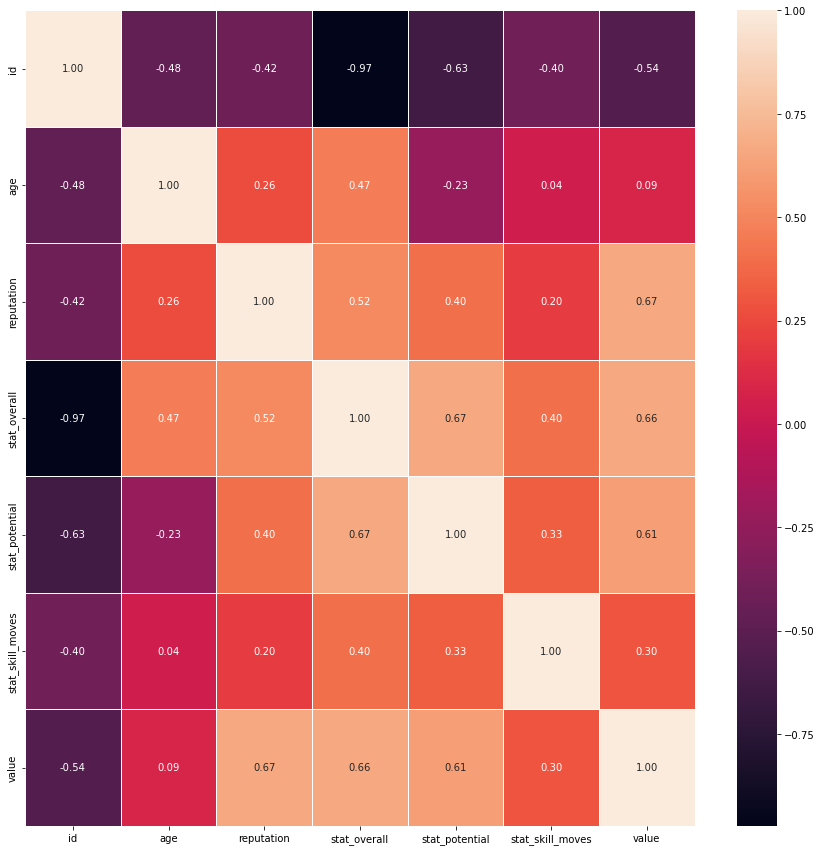

In [8]:
fig,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

In [9]:
train['contract_until'].unique()

array(['2021', '2020', '2019', '2023', '2022', '2024', 'Jun 30, 2019',
       '2026', 'Dec 31, 2018', '2018', '2025', 'Jun 30, 2020',
       'May 31, 2020', 'May 31, 2019', 'Jan 31, 2019', 'Jan 1, 2019',
       'Jan 12, 2019'], dtype=object)

In [10]:
def separate_year(train):
    for i in train.contract_until.unique():
        if len(i) > 4:
            x = i.split(' ')
            train['contract_until'] = train['contract_until'].replace(i,x[2])
        
    return train  
        
separate_year(train)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8927,16925,S. Adewusi,18,africa,2019,MF,right,1.0,48,63,3.0,60000.0
8928,16936,C. Ehlich,19,europe,2020,DF,right,1.0,47,59,2.0,40000.0
8929,16941,N. Fuentes,18,south america,2021,DF,right,1.0,47,64,2.0,50000.0
8930,16942,J. Milli,18,europe,2021,GK,right,1.0,47,65,1.0,50000.0


In [11]:
train = train.astype({'contract_until':'int16'})
train

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8927,16925,S. Adewusi,18,africa,2019,MF,right,1.0,48,63,3.0,60000.0
8928,16936,C. Ehlich,19,europe,2020,DF,right,1.0,47,59,2.0,40000.0
8929,16941,N. Fuentes,18,south america,2021,DF,right,1.0,47,64,2.0,50000.0
8930,16942,J. Milli,18,europe,2021,GK,right,1.0,47,65,1.0,50000.0


In [12]:
def calcurate_year(train):
    for i in train.contract_until:
        train['remaining_contract_years'] = train['contract_until']-2018
        return train
calcurate_year(train)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,remaining_contract_years
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0,3
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0,2
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0,3
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0,2
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927,16925,S. Adewusi,18,africa,2019,MF,right,1.0,48,63,3.0,60000.0,1
8928,16936,C. Ehlich,19,europe,2020,DF,right,1.0,47,59,2.0,40000.0,2
8929,16941,N. Fuentes,18,south america,2021,DF,right,1.0,47,64,2.0,50000.0,3
8930,16942,J. Milli,18,europe,2021,GK,right,1.0,47,65,1.0,50000.0,3


In [13]:
train.contract_until.value_counts()

2019    2899
2021    2308
2020    2051
2022     761
2023     506
2018     391
2024      12
2025       3
2026       1
Name: contract_until, dtype: int64

In [14]:
train.remaining_contract_years.value_counts()

1    2899
3    2308
2    2051
4     761
5     506
0     391
6      12
7       3
8       1
Name: remaining_contract_years, dtype: int64

In [15]:
def change_continent(train):
    for i in train.continent.unique():
        if i == 'south ameica':
            #x = i.replace('south ameica','south_ameica')
            x = 'south_america'
            train['continent'] = train['continent'].replace(i,x)
        
    return train  
        
change_continent(train)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,remaining_contract_years
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0,3
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0,2
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0,3
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0,2
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927,16925,S. Adewusi,18,africa,2019,MF,right,1.0,48,63,3.0,60000.0,1
8928,16936,C. Ehlich,19,europe,2020,DF,right,1.0,47,59,2.0,40000.0,2
8929,16941,N. Fuentes,18,south america,2021,DF,right,1.0,47,64,2.0,50000.0,3
8930,16942,J. Milli,18,europe,2021,GK,right,1.0,47,65,1.0,50000.0,3


In [16]:
train.continent.unique()

array(['south america', 'europe', 'africa', 'asia', 'oceania'],
      dtype=object)

In [17]:
train = train.replace('south america','south_america')
train

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,remaining_contract_years
0,0,L. Messi,31,south_america,2021,ST,left,5.0,94,94,4.0,110500000.0,3
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0,2
2,7,L. Suárez,31,south_america,2021,ST,right,5.0,91,91,3.0,80000000.0,3
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0,2
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927,16925,S. Adewusi,18,africa,2019,MF,right,1.0,48,63,3.0,60000.0,1
8928,16936,C. Ehlich,19,europe,2020,DF,right,1.0,47,59,2.0,40000.0,2
8929,16941,N. Fuentes,18,south_america,2021,DF,right,1.0,47,64,2.0,50000.0,3
8930,16942,J. Milli,18,europe,2021,GK,right,1.0,47,65,1.0,50000.0,3


### one-hot encoding

In [18]:
dum_position = pd.get_dummies(train['position'])
print(dum_position,'\n','~'*90,'\n')
dum_continent = pd.get_dummies(train['continent'])
print(dum_continent,'\n','~'*90,'\n')
#dum_contract_until = pd.get_dummies(train['contract_until'])
#print(dum_contract_until,'\n','~'*90,'\n')
dum_prefer_foot = pd.get_dummies(train['prefer_foot'])
print(dum_prefer_foot)

      DF  GK  MF  ST
0      0   0   0   1
1      0   1   0   0
2      0   0   0   1
3      1   0   0   0
4      0   1   0   0
...   ..  ..  ..  ..
8927   0   0   1   0
8928   1   0   0   0
8929   1   0   0   0
8930   0   1   0   0
8931   0   0   0   1

[8932 rows x 4 columns] 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

      africa  asia  europe  oceania  south_america
0          0     0       0        0              1
1          0     0       1        0              0
2          0     0       0        0              1
3          0     0       1        0              0
4          0     0       1        0              0
...      ...   ...     ...      ...            ...
8927       1     0       0        0              0
8928       0     0       1        0              0
8929       0     0       0        0              1
8930       0     0       1        0              0
8931       0     0       1        0              0

[8932 rows x 5 

In [19]:
train_numeric = train.drop(['contract_until','prefer_foot','continent','position','name','value'],axis=1)
train_numeric

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,remaining_contract_years
0,0,31,5.0,94,94,4.0,3
1,3,27,4.0,91,93,1.0,2
2,7,31,5.0,91,91,3.0,3
3,8,32,4.0,91,91,3.0,2
4,9,25,3.0,90,93,1.0,3
...,...,...,...,...,...,...,...
8927,16925,18,1.0,48,63,3.0,1
8928,16936,19,1.0,47,59,2.0,2
8929,16941,18,1.0,47,64,2.0,3
8930,16942,18,1.0,47,65,1.0,3


In [20]:
ohe_train = pd.concat([train_numeric,dum_prefer_foot,dum_continent,dum_position],axis=1)
ohe_train

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,remaining_contract_years,left,right,africa,asia,europe,oceania,south_america,DF,GK,MF,ST
0,0,31,5.0,94,94,4.0,3,1,0,0,0,0,0,1,0,0,0,1
1,3,27,4.0,91,93,1.0,2,0,1,0,0,1,0,0,0,1,0,0
2,7,31,5.0,91,91,3.0,3,0,1,0,0,0,0,1,0,0,0,1
3,8,32,4.0,91,91,3.0,2,0,1,0,0,1,0,0,1,0,0,0
4,9,25,3.0,90,93,1.0,3,0,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927,16925,18,1.0,48,63,3.0,1,0,1,1,0,0,0,0,0,0,1,0
8928,16936,19,1.0,47,59,2.0,2,0,1,0,0,1,0,0,1,0,0,0
8929,16941,18,1.0,47,64,2.0,3,0,1,0,0,0,0,1,1,0,0,0
8930,16942,18,1.0,47,65,1.0,3,0,1,0,0,1,0,0,0,1,0,0


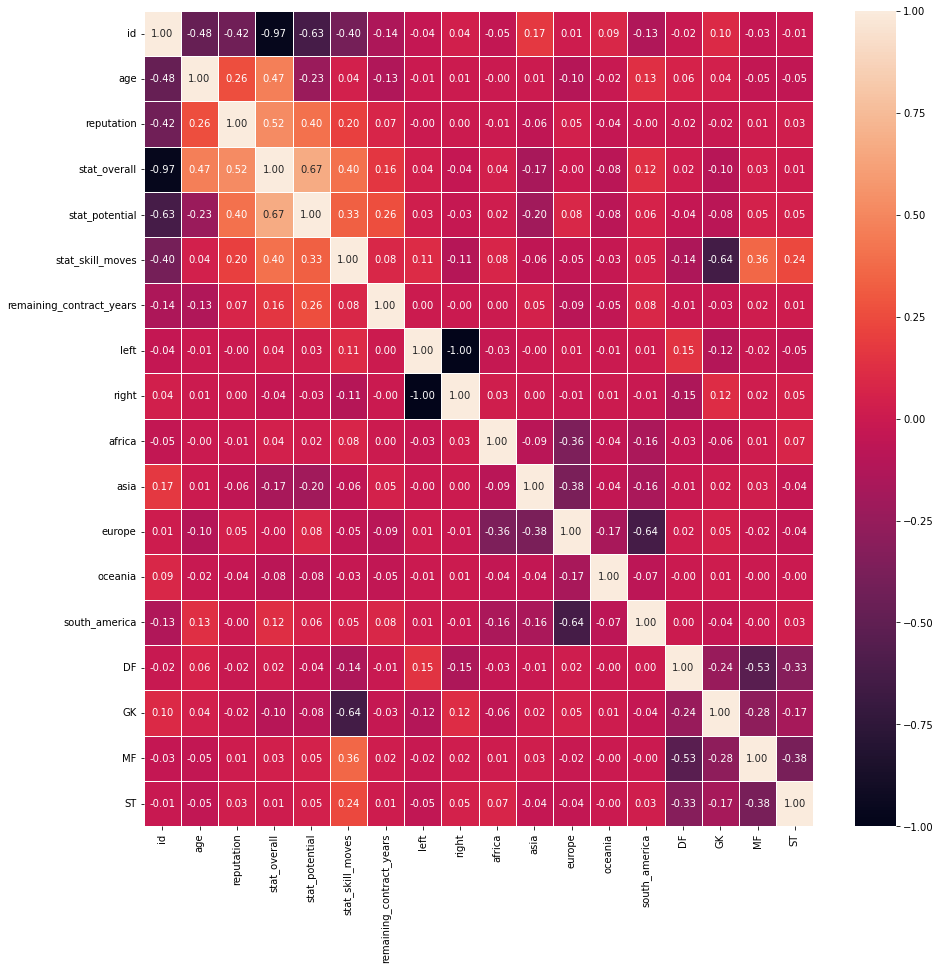

In [21]:
fig,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(ohe_train.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

# IV. 모델링

## 머신러닝

In [22]:
X = ohe_train
y = train['value']

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(7145, 18) (1787, 18) (7145,) (1787,)


### scaler

In [24]:
'''
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
#ohe_test_scaled = scaler.transform(ohe_test)


ohe_train_scaled
'''


'\nscaler = MinMaxScaler()\n\nscaler.fit(X_train)\n\nX_train_scaled = scaler.transform(X_train)\n#ohe_test_scaled = scaler.transform(ohe_test)\n\n\nohe_train_scaled\n'

In [25]:
LGBM_reg =LGBMRegressor()

LGBM_reg.fit(X_train,y_train)

pred_train = LGBM_reg.predict(X_train)
pred_val = LGBM_reg.predict(X_val)

mse_train = mean_squared_error(y_train, pred_train)
mse_val = mean_squared_error(y_val, pred_val)

print(f'mse train: {mse_train} \n\nmse validation: {mse_val}')

mse train: 284138798916.8734 

mse validation: 2337409613287.9243


## 딥러닝

In [26]:
import tensorflow as tf
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [27]:
InputFeature = ohe_train[['reputation','stat_overall','stat_potential','age','stat_skill_moves','remaining_contract_years','left','right','africa','asia','europe','oceania','south_america','DF','GK','MF','ST']]
Label = train['value']

In [28]:
InputFeature.head()

,reputation,stat_overall,stat_potential,age,stat_skill_moves,remaining_contract_years,left,right,africa,asia,europe,oceania,south_america,DF,GK,MF,ST
0,5.0,94,94,31,4.0,3,1,0,0,0,0,0,1,0,0,0,1
1,4.0,91,93,27,1.0,2,0,1,0,0,1,0,0,0,1,0,0
2,5.0,91,91,31,3.0,3,0,1,0,0,0,0,1,0,0,0,1
3,4.0,91,91,32,3.0,2,0,1,0,0,1,0,0,1,0,0,0
4,3.0,90,93,25,1.0,3,0,1,0,0,1,0,0,0,1,0,0


In [29]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

'''
0 = all messages are logged (default behavior)
1 = INFO messages are not printed
2 = INFO and WARNING messages are not printed
3 = INFO, WARNING, and ERROR messages are not printed
'''

'\n0 = all messages are logged (default behavior)\n1 = INFO messages are not printed\n2 = INFO and WARNING messages are not printed\n3 = INFO, WARNING, and ERROR messages are not printed\n'

In [30]:
# model = models.Sequential() 

# model.add(Dense(32, activation='linear',input_shape=(17,))) 
# model.add(Dense(25, activation='linear'))
# model.add(Dense(20, activation='linear'))
# model.add(Dense(16, activation='linear'))
# model.add(Dense(8, activation='linear'))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy',
#              optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [50]:
model = models.Sequential() 

model.add(layers.Dense(input_dim=17, units=64, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=64, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))
model.add(layers.Dropout(rate=0.4))

model.add(layers.Dense(units=1, activation=None)) 



model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                1152      
                                                                 
 activation_9 (Activation)   (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 activation_10 (Activation)  (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 activation_11 (Activation)  (None, 32)                0         
                                                                 
 dropout_3 (Dropout)         (None, 32)               

In [52]:
# Call-back 함수
# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='Models/{epoch:03d}-{loss:.4f}-{accuracy:.4f}.hdf5',
            monitor='loss', verbose=1, save_best_only=True, mode='min')

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK =  [CP, LR] #[LR]

In [53]:
#model.fit(x=InputFeature, y=Label, epochs = 50, shuffle=True, batch_size = 3, callbacks=CALLBACK)
##history = model.fit(InputFeature,Label, batch_size=3, epochs=50,shuffle=True,callbacks=CALLBACK, validation_split=0.3)


Epoch 1/50
2921/2978 [============================>.] - ETA: 0s - loss: -41937992.0000 - accuracy: 0.0000e+00
Epoch 1: loss improved from inf to -42160072.00000, saving model to Models/001--42160072.0000-0.0000.hdf5
2978/2978 [==============================] - 1s 435us/step - loss: -42160072.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 2/50
2924/2978 [============================>.] - ETA: 0s - loss: -40007940.0000 - accuracy: 0.0000e+00
Epoch 2: loss did not improve from -42160072.00000
2978/2978 [==============================] - 1s 430us/step - loss: -40154308.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 3/50
2924/2978 [============================>.] - ETA: 0s - loss: -38648052.0000 - accuracy: 0.0000e+00
Epoch 3: loss did not improve from -42160072.00000
2978/2978 [==============================] - 1s 430us/step - loss: -38538452.0000 - accuracy: 0.0000e+00 - lr: 0.0100
Epoch 4/50
2937/2978 [============================>.] - ETA: 0s - loss: -41713792.0000 - accuracy: 0.0000e+0

2929/2978 [============================>.] - ETA: 0s - loss: -42568324.0000 - accuracy: 0.0000e+00
Epoch 27: loss did not improve from -42372680.00000
2978/2978 [==============================] - 1s 429us/step - loss: -42372648.0000 - accuracy: 0.0000e+00 - lr: 0.0041
Epoch 28/50
2930/2978 [============================>.] - ETA: 0s - loss: -42226852.0000 - accuracy: 0.0000e+00
Epoch 28: loss did not improve from -42372680.00000
2978/2978 [==============================] - 1s 429us/step - loss: -42372632.0000 - accuracy: 0.0000e+00 - lr: 0.0041
Epoch 29/50
2936/2978 [============================>.] - ETA: 0s - loss: -42335412.0000 - accuracy: 0.0000e+00
Epoch 29: loss improved from -42372680.00000 to -42372704.00000, saving model to Models/029--42372704.0000-0.0000.hdf5
2978/2978 [==============================] - 1s 431us/step - loss: -42372704.0000 - accuracy: 0.0000e+00 - lr: 0.0041
Epoch 30/50
2919/2978 [============================>.] - ETA: 0s - loss: -42310300.0000 - accuracy: 0.

In [54]:
model.load_weights("Models/033--42372728.0000-0.0000.hdf5")

In [36]:
# result = model.evaluate(InputFeature, Label)

# print('loss (mean_squared_error) :', result[0])

In [37]:
# history.history.keys()

In [38]:
# loss = history.history['mean_squared_error']
# val_loss = history.history['val_mean_squared_error']

# x_len = np.arange(len(loss))

# plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
# plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

# plt.legend(loc='upper right')
# plt.grid()
# plt.xlabel('epoch')
# plt.ylabel('Loss(MSE)')
# plt.show()

In [39]:
# loss = history.history['mean_squared_error']
# val_loss = history.history['val_mean_squared_error']

# x_len = np.arange(len(loss))

# plt.plot(x_len[80:], loss[80:], marker='.', c='blue', label="Train-set loss.")
# plt.plot(x_len[80:], val_loss[80:], marker='.', c='red', label="Validation-set loss.")

# plt.legend(loc='upper right')
# plt.grid()
# plt.xlabel('epoch')
# plt.ylabel('Loss(MSE)')
# plt.show()

# V. WEP & FLASK

FLASK setting

In [55]:
from flask import Flask, render_template, request, url_for

In [56]:
app = Flask(__name__)

FLASK API

In [57]:
@app.route('/')
@app.route('/valuation')
def predict_valuation():
    reputation = request.args.get('reputation')
    stat_overall = request.args.get('stat_overall')
    stat_potential = request.args.get('stat_potential')
    age = request.args.get('age')
    stat_skill_moves = request.args.get('stat_skill_moves')
    remaining_contract_years = request.args.get('remaining_contract_years')
    left = request.args.get('left')
    right = request.args.get('right')
    africa = request.args.get('africa')
    asia = request.args.get('asia')
    europe = request.args.get('europe')
    oceania = request.args.get('oceania')
    south_america = request.args.get('south_america')
    DF = request.args.get('DF')
    GK = request.args.get('GK')
    MF = request.args.get('MF')
    ST = request.args.get('ST')
    
    
    
    if reputation == None or stat_overall == None or stat_potential == None:
        return render_template('valuation.html',Output = '')
    
    Input = pd.DataFrame({
        'reputation':[float(reputation)],
        'stat_overall':[float(stat_overall)],
        'stat_potential':[float(stat_potential)],
        'age':[float(age)],
        'stat_skill_moves':[float(stat_skill_moves)],
        'remaining_contract_years':[float(remaining_contract_years)],
        'left':[float(left)],
        'right':[float(right)],
        'africa':[float(africa)],
        'asia':[float(asia)],
        'europe':[float(europe)],
        'oceania':[float(oceania)] ,
        'south_america':[float(south_america)],
        'DF':[float(DF)],
        'MF':[float(MF)], 
        'GK':[float(GK)],
        'ST':[float(ST)] 
        
    })
    ModelOutput = model.predict(Input)[0][0]
    
    return render_template('valuation.html', Output = ModelOutput)

In [ ]:
app.run(host='0.0.0.0', port=5000)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://10.186.26.37:5000 (Press CTRL+C to quit)
127.0.0.1 - - [12/Jul/2022 17:46:23] "GET / HTTP/1.1" 200 -
